# BAS RVG1 – Dialektbezogene WER-Auswertung

Dieses Notebook lädt die aggregierten Ergebnisse aus `bas_rvg.csv` und untersucht, wie sich die Word Error Rate (WER) des Whisper-Large-V3-Modells in Abhängigkeit von der Selbstangabe der Sprecher:innen (`dialect_self`) verhält.

Die folgenden Schritte werden durchgeführt:
- Daten und Metadaten aus dem angegebenen `OUTPUT_PATH` laden
- Grundlegende Kennzahlen und die Verteilung der WER visualisieren
- Dialektangaben bereinigen, um vergleichbare Gruppen zu bilden
- Durchschnittliche WER je Dialektgruppe analysieren und grafisch darstellen


In [1]:
from __future__ import annotations

import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import paths

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)


In [2]:
output_root = Path(paths.OUTPUT_PATH or "").expanduser()
if not output_root.is_dir():
    raise FileNotFoundError("OUTPUT_PATH ist nicht gesetzt oder verweist auf kein existierendes Verzeichnis.")

csv_path = output_root / "bas_rvg.csv"
if not csv_path.is_file():
    raise FileNotFoundError(f"Erwartete Datei {csv_path} wurde nicht gefunden.")

df = pd.read_csv(csv_path)
# rename hocheutsch/süd to hochdeutsch/süd
df["dialect_self"] = df["dialect_self"].str.replace("hocheutsch/süd", "hochdeutsch/süd", regex=False)
# convert whisper_large_v3_
df["whisper_large_v3_wer"] = pd.to_numeric(df["whisper_large_v3_wer"], errors="coerce")

print(f"Anzahl Sprecher:innen: {len(df):,}")
df[["speaker_id", "dialect_self", "whisper_large_v3_wer"]].head()


Anzahl Sprecher:innen: 414


,speaker_id,dialect_self,whisper_large_v3_wer
0,1,hochdeutsch/süd,0.187970
1,2,hochdeutsch/süd,0.251701
2,3,mittelbairisch,0.270073
3,4,schwäbisch,0.304813
4,5,salzburgerisch,0.245763


In [3]:
missing = df["whisper_large_v3_wer"].isna().sum()
print(f"Fehlende WER-Werte: {missing}")
wer_summary = df["whisper_large_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
wer_summary.to_frame(name="Whisper-Large-V3 BAS RVG1")


Fehlende WER-Werte: 0


,Whisper-Large-V3 BAS RVG1
count,414.000000
mean,0.297289
std,0.203894
min,0.101695
10%,0.173662
25%,0.207479
50%,0.259551
75%,0.349409
90%,0.420125
max,3.168317


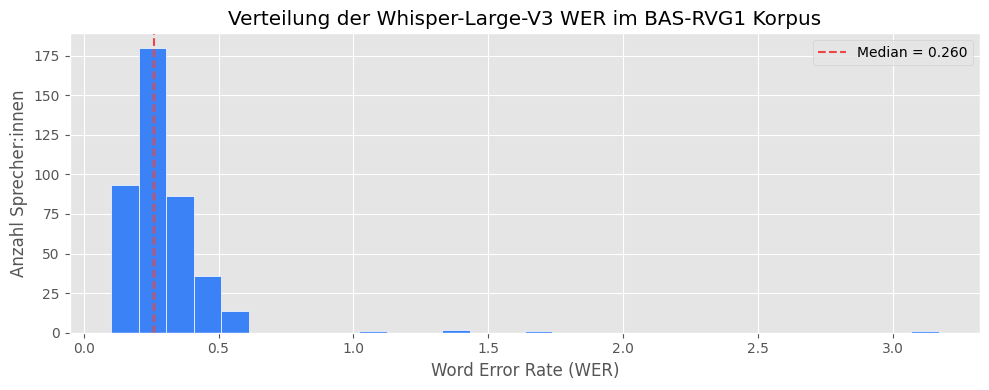

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
wer_values = df["whisper_large_v3_wer"].dropna()
ax.hist(wer_values, bins=30, color="#3B82F6", edgecolor="white")
median_wer = wer_values.median()
ax.axvline(median_wer, color="#EF4444", linestyle="--", label=f"Median = {median_wer:.3f}")
ax.set_xlabel("Word Error Rate (WER)")
ax.set_ylabel("Anzahl Sprecher:innen")
ax.set_title("Verteilung der Whisper-Large-V3 WER im BAS-RVG1 Korpus")
ax.legend()
plt.tight_layout()


In [5]:
DIALECT_FALLBACK = "Unbekannt"

def normalize_dialect(value: str) -> str:
    """Leitet eine kompakte Dialektgruppe aus `dialect_self` ab."""
    if not isinstance(value, str):
        return DIALECT_FALLBACK
    cleaned = re.sub(r"\(.*?\)", "", value)
    primary = re.split(r"[\\/.,;]", cleaned)[0]
    primary = re.sub(r"[^0-9A-Za-zÄÖÜäöüß]+", " ", primary)
    primary = primary.strip()
    if not primary:
        return DIALECT_FALLBACK
    normalized = primary.lower()
    normalized = normalized.replace("ae", "ä").replace("oe", "ö").replace("ue", "ü")
    return normalized.title()

df["dialect_group"] = df["dialect_self"].apply(normalize_dialect)
df[["dialect_self", "dialect_group"]].head(10)


,dialect_self,dialect_group
0,hochdeutsch/süd,Hochdeutsch
1,hochdeutsch/süd,Hochdeutsch
2,mittelbairisch,Mittelbairisch
3,schwäbisch,Schwäbisch
4,salzburgerisch,Salzburgerisch
5,bairisch,Bairisch
6,hochdeutsch/süd,Hochdeutsch
7,nordbairisch,Nordbairisch
8,bairisch,Bairisch
9,bairisch,Bairisch


In [6]:
metrics = (
    df.dropna(subset=["whisper_large_v3_wer"])
      .groupby("dialect_group")
      .agg(
          samples=("whisper_large_v3_wer", "count"),
          mean_wer=("whisper_large_v3_wer", "mean"),
          median_wer=("whisper_large_v3_wer", "median"),
          std_wer=("whisper_large_v3_wer", "std"),
          wer_p25=("whisper_large_v3_wer", lambda s: s.quantile(0.25)),
          wer_p75=("whisper_large_v3_wer", lambda s: s.quantile(0.75)),
      )
)

min_samples = 5
dialect_overview = (
    metrics.loc[metrics["samples"] >= min_samples]
    .sort_values("mean_wer")
    .round({"mean_wer": 3, "median_wer": 3, "std_wer": 3, "wer_p25": 3, "wer_p75": 3})
)

print(f"Dialektgruppen mit mindestens {min_samples} Sprecher:innen: {len(dialect_overview)}")
dialect_overview


Dialektgruppen mit mindestens 5 Sprecher:innen: 19


,samples,mean_wer,median_wer,std_wer,wer_p25,wer_p75
dialect_group,,,,,,
Wienerisch,5,0.213,0.173,0.076,0.172,0.208
Westfälisch,11,0.232,0.211,0.085,0.202,0.239
Kölsch,5,0.235,0.256,0.052,0.202,0.272
Allgäürisch,6,0.244,0.223,0.085,0.193,0.250
Hamburgisch,5,0.267,0.218,0.146,0.202,0.296
Norddeutsch,26,0.269,0.272,0.094,0.186,0.355
Berlinerisch,10,0.271,0.254,0.071,0.239,0.307
Pfälzisch,6,0.274,0.280,0.087,0.220,0.348
Hochdeutsch,48,0.277,0.237,0.144,0.204,0.288


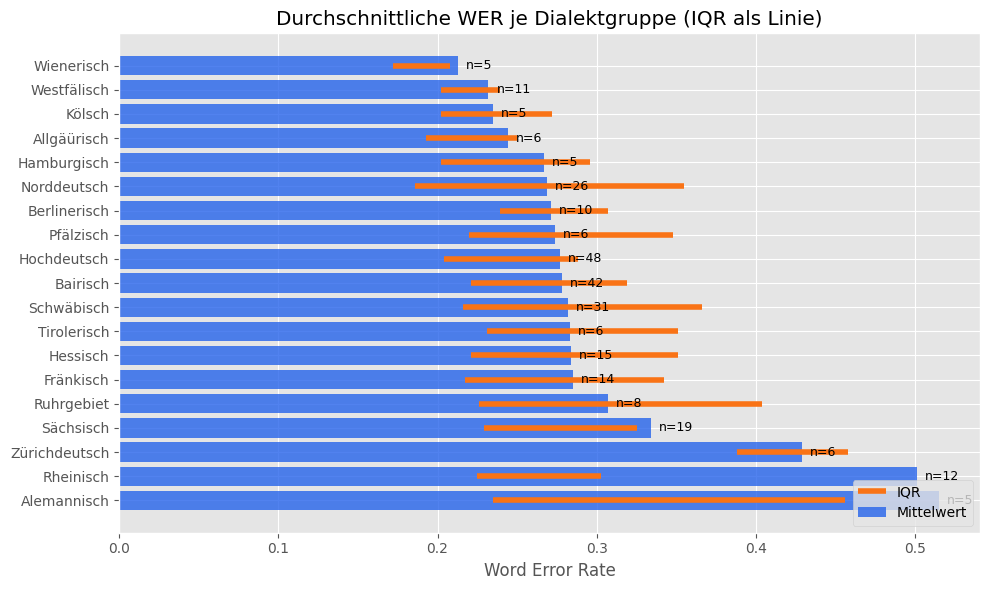

In [7]:
plot_df = dialect_overview
if plot_df.empty:
    print("Keine Dialektgruppen erfüllen die Mindestanzahl für die Visualisierung.")
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    y_positions = list(range(len(plot_df)))
    ax.barh(y_positions, plot_df["mean_wer"], color="#2563EB", alpha=0.8, label="Mittelwert")
    for idx, (lower, upper) in enumerate(zip(plot_df["wer_p25"], plot_df["wer_p75"])):
        ax.hlines(idx, lower, upper, color="#F97316", linewidth=4, label="IQR" if idx == 0 else "")
    for idx, (mean, samples) in enumerate(zip(plot_df["mean_wer"], plot_df["samples"])):
        ax.text(mean + 0.005, idx, f"n={samples}", va="center", fontsize=9)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(plot_df.index)
    ax.set_xlabel("Word Error Rate")
    ax.set_title("Durchschnittliche WER je Dialektgruppe (IQR als Linie)")
    ax.invert_yaxis()
    ax.legend(loc="lower right")
    plt.tight_layout()


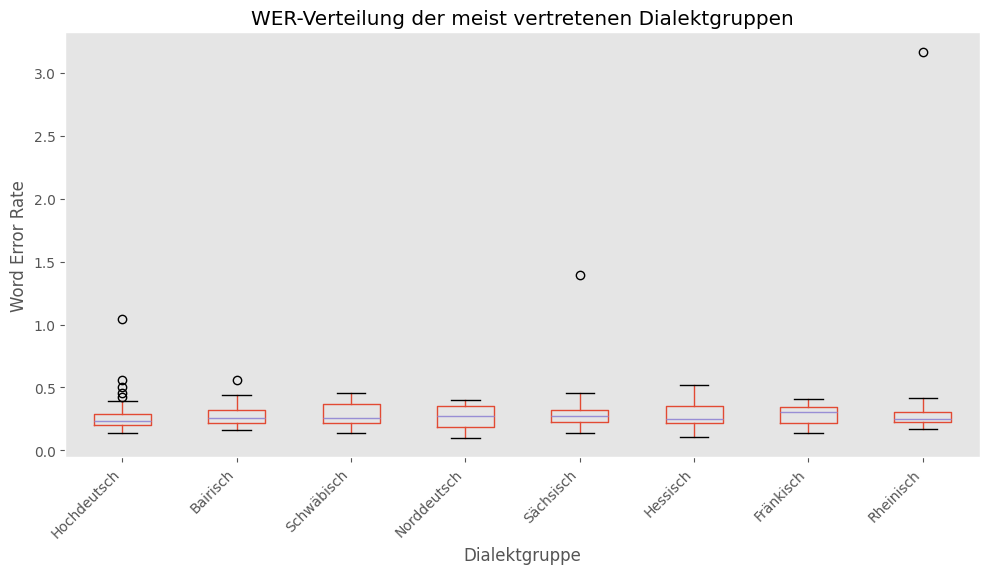

In [8]:
top_groups = metrics.sort_values("samples", ascending=False).head(8).index
subset = df[df["dialect_group"].isin(top_groups)].copy()
if subset.empty:
    print("Keine ausreichenden Daten für die Boxplot-Visualisierung.")
else:
    subset["dialect_group"] = pd.Categorical(subset["dialect_group"], categories=top_groups, ordered=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    subset.boxplot(column="whisper_large_v3_wer", by="dialect_group", ax=ax, grid=False)
    ax.set_ylabel("Word Error Rate")
    ax.set_xlabel("Dialektgruppe")
    ax.set_title("WER-Verteilung der meist vertretenen Dialektgruppen")
    plt.suptitle("")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()


**Hinweise**
- Die Normalisierung der Dialektangaben reduziert Schreibvarianten (z. B. `/`, Klammern, Umlaute) auf konsistente Gruppen.
- Einzelne Sprecher:innen mit extrem hohen WER-Werten können Ausreißer darstellen und sollten für fundierte Analysen genauer geprüft werden.
- Für feinere Analysen lassen sich die Filterparameter (`min_samples`, `top_groups`) im Notebook anpassen.
